In [174]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [152]:
%matplotlib inline
pd.options.display.float_format ='{:,.3f}'.format
%config InlineBackend.figure_format = 'svg' 

In [1047]:
train_data = pd.read_csv('data/train.csv')
train_data

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.000",NaN,0.000,11.000,26.300,"685,960.000",1.000,NaN,1.000,debt consolidation,Short Term,"99,999,999.000","47,386.000","7,914.000",749.000,0
1,Own Home,"1,025,487.000",10+ years,0.000,15.000,15.300,"1,181,730.000",0.000,NaN,0.000,debt consolidation,Long Term,"264,968.000","394,972.000","18,373.000",737.000,1
2,Home Mortgage,"751,412.000",8 years,0.000,11.000,35.000,"1,182,434.000",0.000,NaN,0.000,debt consolidation,Short Term,"99,999,999.000","308,389.000","13,651.000",742.000,0
3,Own Home,"805,068.000",6 years,0.000,8.000,22.500,"147,400.000",1.000,NaN,1.000,debt consolidation,Short Term,"121,396.000","95,855.000","11,338.000",694.000,0
4,Rent,"776,264.000",8 years,0.000,13.000,13.600,"385,836.000",1.000,NaN,0.000,debt consolidation,Short Term,"125,840.000","93,309.000","7,180.000",719.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,"402,192.000",< 1 year,0.000,3.000,8.500,"107,866.000",0.000,NaN,0.000,other,Short Term,"129,360.000","73,492.000","1,900.000",697.000,0
7496,Home Mortgage,"1,533,984.000",1 year,0.000,10.000,26.500,"686,312.000",0.000,43.000,0.000,debt consolidation,Long Term,"444,048.000","456,399.000","12,783.000","7,410.000",1
7497,Rent,"1,878,910.000",6 years,0.000,12.000,32.100,"1,778,920.000",0.000,NaN,0.000,buy a car,Short Term,"99,999,999.000","477,812.000","12,479.000",748.000,0
7498,Home Mortgage,NaN,NaN,0.000,21.000,26.500,"1,141,250.000",0.000,NaN,0.000,debt consolidation,Short Term,"615,274.000","476,064.000","37,118.000",NaN,0


In [1100]:
def prepare_data(data):
    #prepared_data = pd.DataFrame()
    #prepared_data = pd.get_dummies(train_data.loc[:,['Home Ownership', 'Purpose']], prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    transform_dict = {'< 1 year':0, '10+ years':100, '2 years':2, '3 years':3, '5 years':5, '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}
    #transform_dict = {'< 1 year':0, '10+ years':1, '2 years':0, '3 years':0, '5 years':0, '1 year':0, '4 years':0, '6 years':0, '7 years':0, '8 years':0, '9 years':0}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    prepared_data['Term'] = data['Term'].replace({'Long Term':0, 'Short Term':1}, None)
    #prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if x>1000 else x)
    #prepared_data['Tax Liens'] = data['Tax Liens'].apply(lambda x: 0 if x == 0 else 1)
    #prepared_data['Number of Credit Problems'] = data['Number of Credit Problems'].apply(lambda x: 0 if x == 0 else 1)
    #prepared_data['Bankruptcies'] = data['Bankruptcies'].apply(lambda x: 0 if x == 0 else 1)
    threshold = 100000000
    #prepared_data['Maximum Open Credit'] = data['Maximum Open Credit'].apply(lambda x: threshold if x> threshold else x)

    return prepared_data

In [1167]:
#train_data_prepared = prepare_data(train_data)
train_data.iloc[:,:16].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"5,943.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","3,419.000","7,486.000","7,500.000","7,500.000","7,500.000","5,943.000"
mean,"1,366,391.720",0.030,11.131,18.317,"945,153.727",0.170,34.693,0.117,"11,873,177.445","289,833.235","18,314.454","1,151.087"
std,"845,339.200",0.272,4.909,7.042,"16,026,216.671",0.499,21.689,0.347,"31,926,122.975","317,871.382","11,926.765","1,604.451"
min,"164,597.000",0.000,2.000,4.000,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000
25%,"844,341.000",0.000,8.000,13.500,"279,229.500",0.000,16.000,0.000,"180,169.000","114,256.500","10,067.500",711.000
50%,"1,168,386.000",0.000,10.000,17.000,"478,159.000",0.000,32.000,0.000,"309,573.000","209,323.000","16,076.500",731.000
75%,"1,640,137.000",0.000,14.000,21.800,"793,501.500",0.000,50.000,0.000,"519,882.000","360,406.250","23,818.000",743.000
max,"10,149,344.000",7.000,43.000,57.700,"1,304,726,170.000",7.000,118.000,4.000,"99,999,999.000","6,506,797.000","136,679.000","7,510.000"


In [1172]:
def fill_na(data):
    big_value = 10000000000000
    prepared_data = data
    #prepared_data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].median())
    #prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(data['Current Loan Amount'].median())
    #prepared_data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].median())
    prepared_data['Annual Income'] = data['Annual Income'].fillna(100000000)
    #prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(big_value)
    prepared_data['Credit Score'] = data['Credit Score'].fillna(100000)
    
    #prepared_data['Years in current job'] = data['Years in current job'].fillna(0)
    prepared_data['Years in current job'] = data['Years in current job'].fillna(1000)
    #prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1)) 
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(100)  
    prepared_data = prepared_data.drop('Months since last delinquent', axis=1)
    #prepared_data['Months since last delinquent'] = data['Months since last delinquent'].fillna(big_value)
    return prepared_data

In [1091]:
def parameter_fit(parameter):
    pp = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    return pp.fit(np.array(parameter).reshape(-1, 1)) 

def preprocessing_data_fit(data):
    fits = {}  
    #fits['Years of Credit History'] = parameter_fit(data['Years of Credit History'])
    #fits['Number of Open Accounts'] = parameter_fit(data['Number of Open Accounts'])
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
    fits['Annual Income'] = pt.fit(np.array(data['Annual Income']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Number of Open Accounts'] = pt.fit(np.array(data['Number of Open Accounts']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Years of Credit History'] = pt.fit(np.array(data['Years of Credit History']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Current Loan Amount'] = pt.fit(np.array(data['Current Loan Amount']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)  
    fits['Current Credit Balance'] = pt.fit(np.array(data['Current Credit Balance']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Monthly Debt'] = pt.fit(np.array(data['Monthly Debt']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Credit Score'] = pt.fit(np.array(data['Credit Score']).reshape(-1, 1))
    #pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    #fits['Months since last delinquent'] = pt.fit(np.array(data['Months since last delinquent']).reshape(-1, 1))
    
    ss = preprocessing.StandardScaler()
    fits['Years in current job'] = ss.fit(np.array(data['Years in current job']).reshape(-1, 1))
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    fits['Maximum Open Credit'] = qt.fit(np.array(train_data_prepared['Maximum Open Credit']).reshape(-1, 1))

    return fits

In [1103]:
def preprocessing_data_transform(data, fits):
    prepared_data = data   
    for key in fits:
        print(key)
        prepared_data[key] = pd.DataFrame(fits[key].transform(np.array(data[key]).reshape(-1, 1)))
    return prepared_data

In [1173]:
train_data_prepared = prepare_data(train_data)
train_data_prepared = fill_na(train_data_prepared)
#fits = preprocessing_data_fit(train_data_prepared)
#train_data_prepared = preprocessing_data_transform(train_data_prepared, fits)
train_data_prepared.iloc[:,:13].describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000"
mean,"21,842,728.799",83.040,0.030,11.131,18.317,"945,153.727",0.170,0.304,0.741,"11,873,177.445","289,833.235","18,314.454","21,330.597"
std,"40,014,425.773",213.777,0.272,4.909,7.042,"16,026,216.671",0.499,4.326,0.438,"31,926,122.975","317,871.382","11,926.765","40,269.509"
min,"164,597.000",0.000,0.000,2.000,4.000,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000
25%,"931,133.000",3.000,0.000,8.000,13.500,"279,229.500",0.000,0.000,0.000,"180,169.000","114,256.500","10,067.500",715.000
50%,"1,398,172.000",6.000,0.000,10.000,17.000,"478,159.000",0.000,0.000,1.000,"309,573.000","209,323.000","16,076.500",736.000
75%,"2,780,574.000",100.000,0.000,14.000,21.800,"793,501.500",0.000,0.000,1.000,"519,882.000","360,406.250","23,818.000",748.000
max,"100,000,000.000","1,000.000",7.000,43.000,57.700,"1,304,726,170.000",7.000,100.000,1.000,"99,999,999.000","6,506,797.000","136,679.000","100,000.000"


<AxesSubplot:>

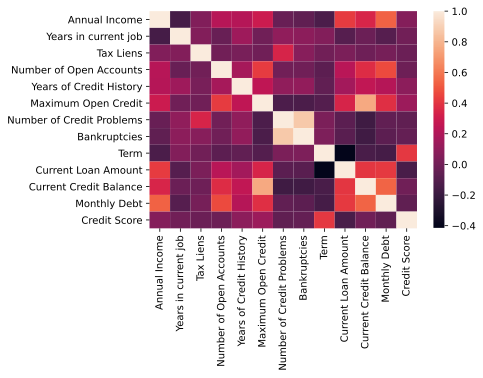

In [876]:
sns.heatmap(train_data_prepared.iloc[:,:13].corr())

In [877]:
#pipe = make_pipeline(StandardScaler(), LogisticRegression())
#pipe.fit(X_train, y_train)

## Обучение

In [1174]:
target = 'Credit Default'
X = np.array(train_data_prepared.iloc[:, train_data_prepared.columns != target])
y = train_data_prepared[target].astype(int)
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
#imbalance
ros = RandomOverSampler(random_state=0)
X_train_validation, y_train_validation = ros.fit_resample(X_train_validation, y_train_validation)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.20, random_state=1)
d_x_test = xgb.DMatrix(X_test, label=y_test)
d_train_val = xgb.DMatrix(X_resampled, label=y_resampled)
d_train = xgb.DMatrix(X_train, label=y_train)
d_val = xgb.DMatrix(X_validation, label=y_validation)

In [1175]:
#history = {'param':[], 'train-auc':[], 'test-auc':[], 'train-error':[], 'test-error':[], 'train-logloss':[], 'test-logloss':[], 'epohs':[]}
history = {'param':[], 'auc':[], 'f1_score':[], 'epohs':[]}

for i in range (1):
    #param_value=0.001*(2**i)
    param_value=i*0.1
    print(param_value)
    
    param = {'max_depth': 8, 
         'eta': 0.3, 
         'objective': 'binary:logistic', 
         'subsample': 0.8, 
         'gamma': 20, 
         'min_child_weight':1,
         'reg_lambda': 0, 
         'reg_alpha':0, 
         'max_delta_step':0,
         'colsample_bynode':0.9,#0.5
         'colsample_bytree':1,
         'colsample_bylevel':0.9#0.5
            } 
    param['eval_metric'] = ['auc', 'logloss']

    #res = xgb.cv(param, d_train_val, 1000, nfold=5, metrics=param['eval_metric'], as_pandas=False, seed=0, stratified=False,callbacks=[xgb.callback.EarlyStopping(10)])#xgb.callback.EvaluationMonitor(show_stdv=False), 
    bst = xgb.train(param, d_train, 2000, evallist, verbose_eval=10, evals_result=hist, early_stopping_rounds=10)
    #bst.save_model('0001.model')

    ypred = bst.predict(d_x_test, iteration_range=(0, bst.best_iteration))
    threshold = 0.5
    predictions = [1 if val > threshold else 0 for val in ypred]
    print(f'f1_score: {f1_score(y_test, predictions, average="binary")}')
    print(f'auc: {roc_auc_score(y_test, predictions)}')
    print(confusion_matrix(y_test, predictions))
    print(f'acc: {accuracy_score(y_test, predictions)}')
    
    history['param'].append(param_value)
    history['f1_score'].append(f1_score(y_test, predictions, average='binary'))
    history['auc'].append(roc_auc_score(y_test, predictions))
    #history['train-auc'].append(res['train-auc-mean'][-1])
    #history['test-auc'].append(res['test-auc-mean'][-1])
    #history['train-logloss'].append(res['train-logloss-mean'][-1])
    #history['test-logloss'].append(res['test-logloss-mean'][-1])
    history['epohs'].append(len(hist['train']['auc']))

0.0
[0]	train-auc:0.59252	train-logloss:0.69017	eval-auc:0.58005	eval-logloss:0.69097
[9]	train-auc:0.62047	train-logloss:0.70234	eval-auc:0.61039	eval-logloss:0.70407
f1_score: 0.5109745390693591
auc: 0.6466642960153303
[[652 425]
 [132 291]]
acc: 0.6286666666666667


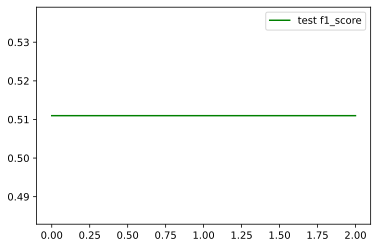

In [1163]:
start = 0
plt.clf()
epochs = history['param'][start:]#
plt.plot(epochs, history['f1_score'][start:], 'g', label='test f1_score')
plt.legend()
plt.show()

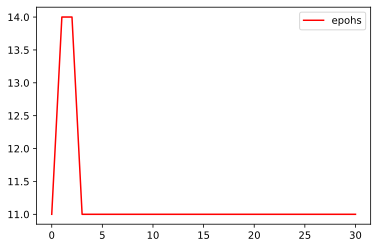

In [1135]:
plt.clf()
epochs = history['param']#range(1, len(history['test-auc']) + 1)#
plt.plot(epochs, history['epohs'], 'r', label='epohs')
plt.legend()
plt.show()

In [1113]:
history = {'param':[], 'auc':[], 'f1_score':[], 'epohs':[]}

for i in range (1):
    #param_value=0.001*(2**i)
    param_value=i*0.1
    print(param_value)
    rf = xgb.XGBRFClassifier(n_estimators=40, max_depth=8, learning_rate=0.3, verbosity=1, objective='binary:logistic',
                             gamma=19, min_child_weight=0, max_delta_step=3, subsample=0.8, colsample_bynode=0.9, colsample_bylevel=0.9,
                             reg_lambda=0.2, reg_alpha=0).fit(X_train, y_train, eval_metric=['auc','logloss'])
    ypred = rf.predict(X_test)
    threshold = 0.5
    predictions = [1 if val > threshold else 0 for val in ypred]
    print(f'f1_score: {f1_score(y_test, predictions, average="binary")}')
    print(f'auc: {roc_auc_score(y_test, predictions)}')
    print(confusion_matrix(y_test, predictions))
    print(f'acc: {accuracy_score(y_test, predictions)}')

    history['param'].append(param_value)
    history['f1_score'].append(f1_score(y_test, predictions, average='binary'))
    history['auc'].append(roc_auc_score(y_test, predictions))
    #history['train-auc'].append(res['train-auc-mean'][-1])
    #history['test-auc'].append(res['test-auc-mean'][-1])
    #history['train-logloss'].append(res['train-logloss-mean'][-1])
    #history['test-logloss'].append(res['test-logloss-mean'][-1])
    history['epohs'].append(len(hist['train']['auc']))

0.0


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5162393162393162
auc: 0.6383752691008415
[[632 422]
 [144 302]]
acc: 0.6226666666666667


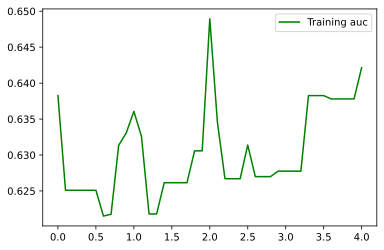

In [684]:
plt.clf()
epochs = history['param']#
plt.plot(epochs, history['auc'], 'g', label='Training auc')
plt.legend()
plt.show()

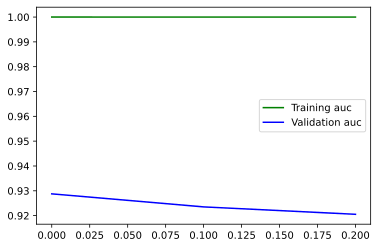

In [637]:
plt.clf()
epochs = history['param']#
plt.plot(epochs, history['train-auc'], 'g', label='Training auc')
plt.plot(epochs, history['test-auc'], 'b', label='Validation auc')
plt.legend()
plt.show()

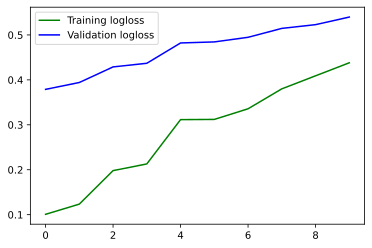

In [633]:
plt.clf()
epochs = history['param']#
plt.plot(epochs, history['train-logloss'], 'g', label='Training logloss')
plt.plot(epochs, history['test-logloss'], 'b', label='Validation logloss')
plt.legend()
plt.show()

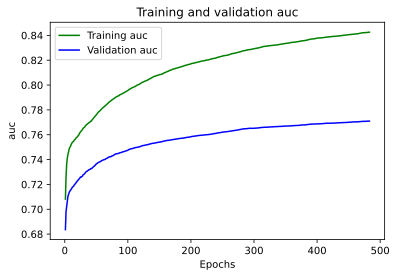

In [567]:
plt.clf()
acc_values = res['train-auc-mean']
val_acc_values = res['test-auc-mean']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training auc')
plt.plot(epochs, val_acc_values, 'b', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

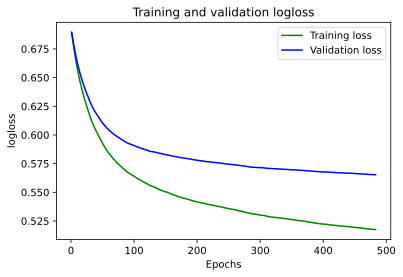

In [568]:
plt.clf()
acc_values = res['train-logloss-mean']
val_acc_values = res['test-logloss-mean']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training loss')
plt.plot(epochs, val_acc_values, 'b', label='Validation loss')
plt.title('Training and validation logloss')
plt.xlabel('Epochs')
plt.ylabel('logloss')
plt.legend()
plt.show()

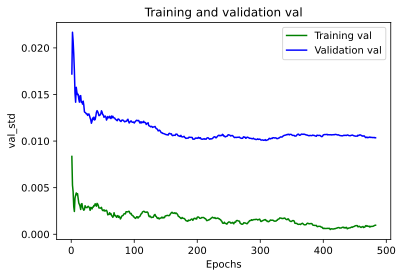

In [570]:
plt.clf()
acc_values = res['train-auc-std']
val_acc_values = res['test-auc-std']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training val')
plt.plot(epochs, val_acc_values, 'b', label='Validation val')
plt.title('Training and validation val')
plt.xlabel('Epochs')
plt.ylabel('val_std')
plt.legend()
plt.show()

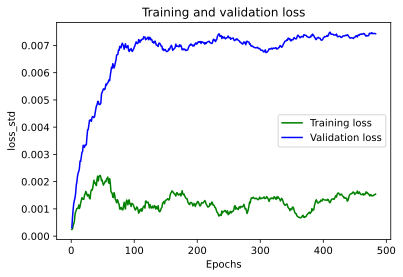

In [569]:
plt.clf()
acc_values = res['train-logloss-std']
val_acc_values = res['test-logloss-std']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training loss')
plt.plot(epochs, val_acc_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss_std')
plt.legend()
plt.show()

In [638]:
evallist = [(d_train, 'train'), (d_val, 'eval')]
hist={}
param = {'max_depth': 6, 
         'eta': 0.3, 
         'objective': 'binary:logistic', 
         'subsample': 0.8, 
         'gamma': 0, 
         'min_child_weight':2,
         'reg_lambda': 2, 
         'reg_alpha':0, 
         'max_delta_step':1} #binary:hinge
param['eval_metric'] = ['auc', 'logloss']

bst = xgb.train(param, d_train, 2000, evallist, verbose_eval=100, evals_result=hist, early_stopping_rounds=10)
bst.save_model('0001.model')

ypred = bst.predict(d_x_test, iteration_range=(0, bst.best_iteration))
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f"f1_score: {f1_score(y_test, predictions, average='binary')}")
print(f'auc: {roc_auc_score(y_test, predictions)}')
print(confusion_matrix(y_test, predictions))
print(f'acc: {accuracy_score(y_test, predictions)}')


[0]	train-auc:0.74770	train-logloss:0.65337	eval-auc:0.69451	eval-logloss:0.66246
[100]	train-auc:0.99612	train-logloss:0.21090	eval-auc:0.88533	eval-logloss:0.43326
[200]	train-auc:0.99996	train-logloss:0.09978	eval-auc:0.91459	eval-logloss:0.38805
[236]	train-auc:1.00000	train-logloss:0.07858	eval-auc:0.91978	eval-logloss:0.38070
f1_score: 0.4194312796208531
auc: 0.5959422351291017
[[833 244]
 [246 177]]
acc: 0.6733333333333333


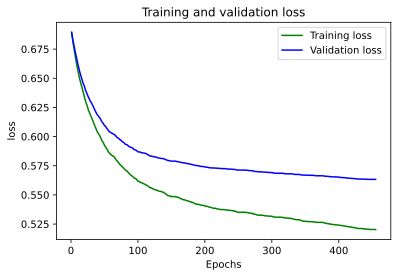

In [572]:
plt.clf()
acc_values = hist['train']['logloss']
val_acc_values = hist['eval']['logloss']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training loss')
plt.plot(epochs, val_acc_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

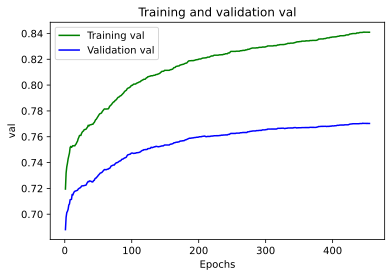

In [573]:
plt.clf()
acc_values = hist['train']['auc']
val_acc_values = hist['eval']['auc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training val')
plt.plot(epochs, val_acc_values, 'b', label='Validation val')
plt.title('Training and validation val')
plt.xlabel('Epochs')
plt.ylabel('val')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

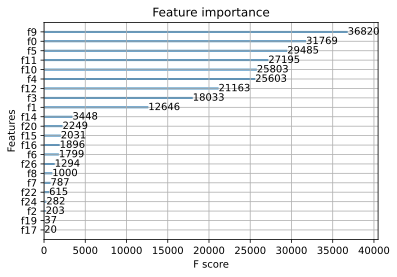

In [482]:
xgb.plot_importance(bst)

In [296]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# Загружаем алгоритмы модели
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# оцениваем модель на каждой итерации
results = []
names = []

for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.153443 (0.028923)
LDA: 0.169727 (0.031575)
KNN: 0.257765 (0.047016)
CART: 0.366056 (0.036965)
NB: 0.165418 (0.154466)
SVM: 0.000000 (0.000000)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [37]:
%%time
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(solver="warn"), parameters)
grid_search.fit(x_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

In [297]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
def dummy_score(strategy_):
    clf_dummy = DummyClassifier(strategy = strategy_)
    clf_dummy.fit(X_train, y_train)
    ypred = clf_dummy.predict(X_test)
    print(f'{strategy_}:')
    print(f'f1_score: {f1_score(y_test, ypred, average="binary")}')
    print(f'roc_auc: {roc_auc_score(ypred, y_test)}')
    print(confusion_matrix(ypred, y_test))
    print()

dummy_score('uniform')
dummy_score('stratified')

uniform:
f1_score: 0.35037720033528913
roc_auc: 0.48913894324853224
[[516 214]
 [561 209]]

stratified:
f1_score: 0.28640192539109505
roc_auc: 0.5066391941391941
[[788 304]
 [289 119]]



In [99]:
clf_dummy.fit(X_train, y_train)
ypred = clf_dummy.predict(X_test)

In [100]:
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f1_score(y_test, predictions, average='binary'))
print(roc_auc_score(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

0.0


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, verbose=1)
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.2s finished


RandomForestClassifier(n_estimators=1000, verbose=1)

In [43]:
ypred = rf.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [45]:
ypred.T

array([1, 1, 1, ..., 1, 1, 1])

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score